In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


pd.options.display.float_format = '{:.2f}'.format

## IMPORT & EXPLORE

#### COLAB

In [2]:

from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/My Drive/Data Science/XrayCT-Disease-Detection/data/lung_tumor/lung_tumor_scan_cases.npz"



# Load data
lung_scans_cases = np.load(data_path)['scan_array']
lung_scans_cases_labels = np.load(data_path)['labels']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### LOCAL

In [ ]:
# Let's laod saved np.array converted images

lung_scan_cases = np.load(r"C:\Users\User\Desktop\lung_tumor_project\ct_scans\scan_arrays\lung_tumor_scan_cases.npz")['scan_array']

lung_scan_cases_labels = np.load(r"C:\Users\User\Desktop\lung_tumor_project\ct_scans\scan_arrays\lung_tumor_scan_cases.npz")['labels']


In [ ]:
lung_scans_cases.shape

(4159, 224, 224, 1)

Shape of this array tells us that : We have 4159 images with 224x224 resolution which is in grayscale,

In [ ]:
pd.Series(lung_scan_cases_labels).value_counts(normalize = True)

2   0.39
0   0.33
1   0.29
Name: proportion, dtype: float64

And we also dealing with near balanced data , as all classes have near equal number of presentations in the "lung_scan_cases_labels" array.

## CLEAN & PREPARE

#### IMAGES TRANSFORMATION

In [3]:
def generate_augmented_images(images, labels, augmentations_per_image=3, zoom_range=(0.9, 1.3)):
    augmented_images = []
    augmented_labels = []

    # Precompute random values for efficiency
    num_total_augs = len(images) * augmentations_per_image
    random_flips_lr = tf.random.uniform([num_total_augs], 0, 2, dtype=tf.int32)
    random_flips_ud = tf.random.uniform([num_total_augs], 0, 2, dtype=tf.int32)
    random_rotations = tf.random.uniform([num_total_augs], 0, 4, dtype=tf.int32)
    random_brightness = tf.random.uniform([num_total_augs], -0.1, 0.1)
    random_contrasts = tf.random.uniform([num_total_augs], 0.8, 1.2)
    zoom_factors = tf.random.uniform([num_total_augs], zoom_range[0], zoom_range[1])

    # Process images
    aug_idx = 0
    for img, lbl in zip(images, labels):
        # Ensure image is properly shaped for grayscale (h, w, 1)
        if len(img.shape) == 2:
            img = tf.expand_dims(img, axis=-1)

        # Safety check: ensure values are within range [0, 1]
        img = tf.clip_by_value(img, 0.0, 1.0)

        h, w, c = img.shape

        for _ in range(augmentations_per_image):
            # Start with a clean copy of the image
            aug_img = tf.identity(img)

            # Apply random horizontal flip
            if random_flips_lr[aug_idx] > 0:
                aug_img = tf.image.flip_left_right(aug_img)

            # Apply random vertical flip
            if random_flips_ud[aug_idx] > 0:
                aug_img = tf.image.flip_up_down(aug_img)

            # Apply random rotation (90-degree increments)
            aug_img = tf.image.rot90(aug_img, k=random_rotations[aug_idx])

            # Apply random brightness with safety check
            aug_img = tf.image.adjust_brightness(aug_img, random_brightness[aug_idx])
            aug_img = tf.clip_by_value(aug_img, 0.0, 1.0)

            # Apply random contrast with safety check
            aug_img = tf.image.adjust_contrast(aug_img, random_contrasts[aug_idx])
            aug_img = tf.clip_by_value(aug_img, 0.0, 1.0)

            # Gaussian noise - optimized for grayscale
            if tf.random.uniform(()) > 0.7:  # Apply with 30% probability
                noise = tf.random.normal(shape=tf.shape(aug_img), mean=0.0, stddev=0.05)
                aug_img = tf.clip_by_value(aug_img + noise, 0.0, 1.0)

            # Random zoom with more robust logic
            zoom_factor = zoom_factors[aug_idx]

            try:
                if zoom_factor > 1.0:  # Zoom in
                    # Ensure new dimensions are at least 1
                    new_h = tf.maximum(tf.cast(h / zoom_factor, tf.int32), 1)
                    new_w = tf.maximum(tf.cast(w / zoom_factor, tf.int32), 1)

                    # Calculate crop position
                    top = (h - new_h) // 2
                    left = (w - new_w) // 2

                    # Ensure valid crop boundaries
                    if new_h > 0 and new_w > 0 and top >= 0 and left >= 0:
                        aug_img = tf.image.crop_to_bounding_box(aug_img, top, left, new_h, new_w)
                        aug_img = tf.image.resize(aug_img, (h, w))
                else:  # Zoom out
                    # Ensure new dimensions don't exceed int32 max
                    new_h = tf.minimum(tf.cast(h * zoom_factor, tf.int32), tf.int32.max)
                    new_w = tf.minimum(tf.cast(w * zoom_factor, tf.int32), tf.int32.max)

                    # Ensure dimensions are at least 1
                    new_h = tf.maximum(new_h, 1)
                    new_w = tf.maximum(new_w, 1)

                    aug_img = tf.image.resize(aug_img, (new_h, new_w))
                    aug_img = tf.image.resize_with_crop_or_pad(aug_img, h, w)
            except tf.errors.InvalidArgumentError:
                # If zoom causes error, skip this transformation
                pass

            # Random gamma adjustment with safety check
            if tf.random.uniform(()) > 0.7:
                gamma = tf.random.uniform([], 0.8, 1.2)
                aug_img = tf.image.adjust_gamma(aug_img, gamma)
                aug_img = tf.clip_by_value(aug_img, 0.0, 1.0)

            # Random cutout (masking) - safer version
            if tf.random.uniform(()) > 0.8:  # Apply with 20% probability
                mask_size_h = tf.maximum(tf.cast(h * tf.random.uniform([], 0.1, 0.2), tf.int32), 1)
                mask_size_w = tf.maximum(tf.cast(w * tf.random.uniform([], 0.1, 0.2), tf.int32), 1)

                # Ensure mask position is valid
                mask_y = tf.minimum(tf.random.uniform([], 0, h - mask_size_h, dtype=tf.int32), h - 1)
                mask_x = tf.minimum(tf.random.uniform([], 0, w - mask_size_w, dtype=tf.int32), w - 1)

                # Create mask
                mask = tf.zeros([mask_size_h, mask_size_w, 1]) + 0.5  # Gray mask
                paddings = [[mask_y, h - mask_y - mask_size_h],
                           [mask_x, w - mask_x - mask_size_w],
                           [0, 0]]

                # Ensure paddings are valid
                paddings = tf.maximum(paddings, 0)

                mask = tf.pad(mask, paddings)
                mask = tf.cast(mask > 0, aug_img.dtype)
                aug_img = aug_img * (1 - mask) + mask * 0.5

            # Final safety check
            aug_img = tf.clip_by_value(aug_img, 0.0, 1.0)

            # Check for NaN values and replace with safe values
            aug_img = tf.where(tf.math.is_nan(aug_img), tf.zeros_like(aug_img), aug_img)

            # Append the augmented image
            augmented_images.append(aug_img.numpy())
            augmented_labels.append(lbl)
            aug_idx += 1

    return np.array(augmented_images), np.array(augmented_labels)

In [4]:
def display_examples(images, labels, num_examples=5):
    plt.figure(figsize=(10, 10))

    for i in range(num_examples):
        ax = plt.subplot(1, num_examples, i + 1)
        ax.imshow(images[i])  # Display the image
        ax.set_title(f"Label: {labels[i]}")  # Display the label
        ax.axis("off")  # Hide axes

    plt.show()

In [5]:
lung_scan_cases , lung_scan_cases_labels = generate_augmented_images( images = lung_scans_cases ,
                                                                      labels = lung_scans_cases_labels ,
                                                                      augmentations_per_image = 2 )

#### PREPARE DATA FOR MODEL BUILDING

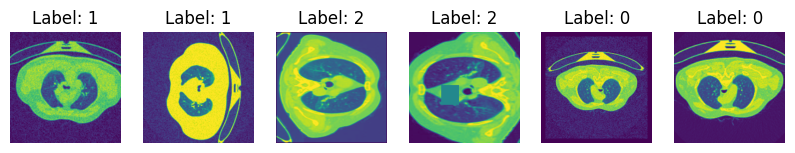

In [6]:
display_examples(images = lung_scan_cases[42:],
                 labels = lung_scan_cases_labels[42:],
                 num_examples=6)

In [7]:
lung_scan_cases.shape

(8318, 224, 224, 1)

In [62]:
from tensorflow.keras import losses
from sklearn.model_selection import train_test_split

In [10]:
# Now , we can split data

lung_scan_cases_train , lung_scan_cases_test , lung_scan_cases_labels_train , lung_scan_cases_labels_test = train_test_split(
    lung_scan_cases ,
    lung_scan_cases_labels ,
    train_size = 0.97 ,
    stratify = lung_scan_cases_labels ,
    random_state = 42
)


In [11]:
# and let's also obtain validation set

lung_scan_cases_train , lung_scan_cases_validation , lung_scan_cases_labels_train , lung_scan_cases_labels_validation = train_test_split(
    lung_scan_cases_train ,
    lung_scan_cases_labels_train ,
    train_size = 0.97 ,
    stratify = lung_scan_cases_labels_train ,
    random_state = 42
)


In [12]:
print(f'ARRAY SHAPES (TRAIN - TEST - VALIDATION) : {lung_scan_cases_train.shape, lung_scan_cases_test.shape, lung_scan_cases_validation.shape}')

ARRAY SHAPES (TRAIN - TEST - VALIDATION) : ((7825, 224, 224, 1), (250, 224, 224, 1), (243, 224, 224, 1))


## MODEL BUILDING

#### BUILDING STRUCTURE

In [13]:
from tensorflow.keras import models , layers , optimizers , regularizers , callbacks

In [71]:
lung_scan_cases_sequential_neural_net = models.Sequential( [


    layers.Conv2D( filters = 32 ,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((3,3)) ,

    layers.Conv2D( filters = 64 ,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((3,3)) ,

    layers.Conv2D( filters = 128 ,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((3,3)),

    layers.Conv2D( filters = 256 ,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((3,3)),
] )

In [72]:
lung_scan_cases_sequential_neural_net.add( layers.GlobalAveragePooling2D()) ,

lung_scan_cases_sequential_neural_net.add( layers.Dense( units = 128 ,
                                                         activation = 'relu') )

lung_scan_cases_sequential_neural_net.add( layers.Dropout(rate = 0.5) )

lung_scan_cases_sequential_neural_net.add( layers.Dense( units = 128 ,
                                                         activation = 'relu') )

lung_scan_cases_sequential_neural_net.add( layers.Dense( units = 3 ,
                                                         activation = 'softmax') )

In [73]:
lung_scan_cases_sequential_neural_net.build( input_shape = (lung_scan_cases_train.shape) )

In [74]:
lung_scan_cases_sequential_neural_net.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)                   │ (7825, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (7825, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (7825, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (7825, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (7825, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (7825, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (7825, 22, 22, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (7825, 22, 22, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (7825, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (7825, 5, 5, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (7825, 5, 5, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (7825, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (7825, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (7825, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (7825, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (7825, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (7825, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 439,555 (1.68 MB)

 Trainable params: 438,595 (1.67 MB)

 Non-trainable params: 960 (3.75 KB)

#### COMPILE

In [75]:
lung_scan_cases_sequential_neural_net.compile( optimizer = optimizers.Adam() ,
                                               loss = losses.SparseCategoricalCrossentropy(),
                                               metrics = ['accuracy'] )

In [76]:
lung_scan_cases_sequential_neural_net_early_stopping = callbacks.EarlyStopping( monitor = 'val_loss',
                                                                                patience = 35 ,
                                                                                restore_best_weights = True )

#### TRAIN

In [77]:
training_history = lung_scan_cases_sequential_neural_net.fit( lung_scan_cases_train ,
                                                              lung_scan_cases_labels_train ,
                                                              validation_data = [lung_scan_cases_validation,lung_scan_cases_labels_validation],
                                                              epochs = 120 ,
                                                              callbacks = [lung_scan_cases_sequential_neural_net_early_stopping],
                                                              batch_size = 32 ,
                                                              verbose = 1 )

Epoch 1/120
245/245 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.4445 - loss: 1.1376 - val_accuracy: 0.3868 - val_loss: 4.2770
Epoch 2/120
245/245 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.5443 - loss: 0.8792 - val_accuracy: 0.5473 - val_loss: 0.9647
Epoch 3/120
245/245 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.6201 - loss: 0.7919 - val_accuracy: 0.4815 - val_loss: 1.0490
Epoch 4/120
245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.6454 - loss: 0.7154 - val_accuracy: 0.6132 - val_loss: 0.7559
Epoch 5/120
245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.6971 - loss: 0.6393 - val_accuracy: 0.7407 - val_loss: 0.5713
Epoch 6/120
245/245 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.7294 - loss: 0.5853 - val_accuracy: 0.7860 - val_loss: 0.5542
Epoch 7/120
245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.7397 - loss: 0.5447 - val_accuracy: 0.7325 - val_loss: 0.6361
Epoch 8/120
245/245 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7934 - loss: 0.46

<Axes: title={'center': 'VAL ACCURACY'}>

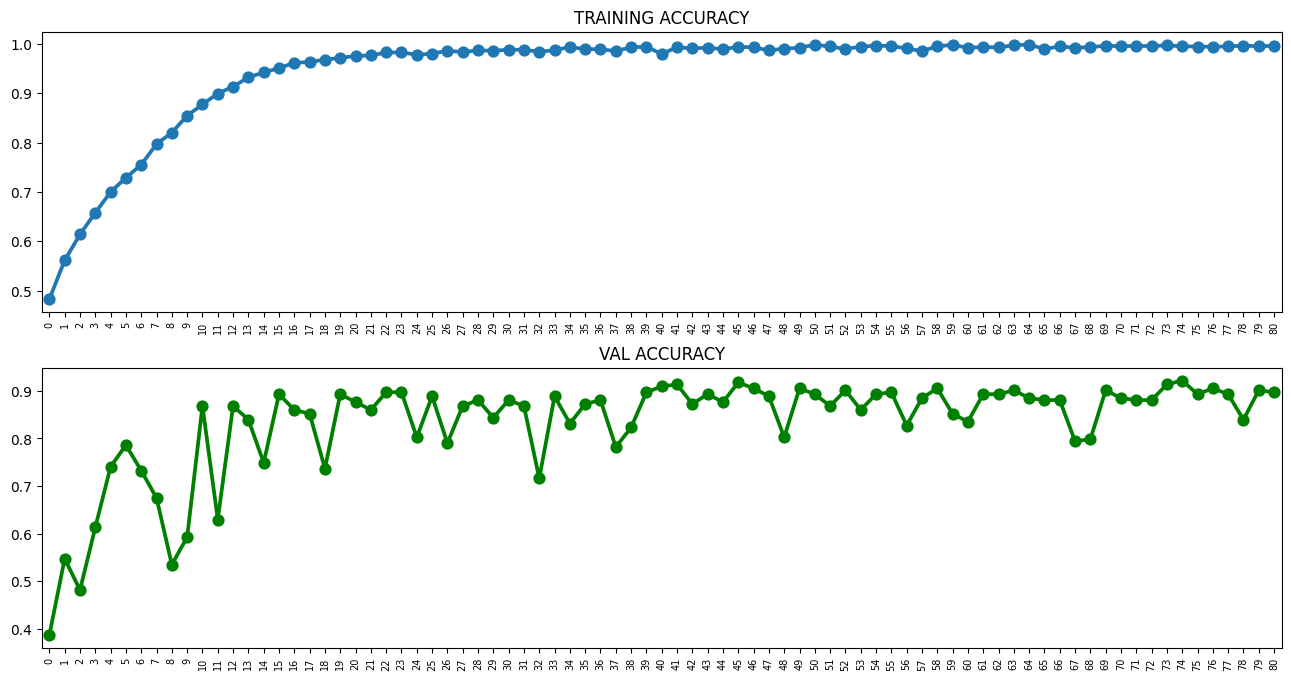

In [78]:


plt.figure(figsize = (16,8))

plt.subplot(2,1,1)

plt.title('TRAINING ACCURACY')
plt.xticks(rotation = 90,fontsize = 7)

sns.pointplot(data = training_history.history,
              x = training_history.epoch ,
              y = training_history.history['accuracy'])



plt.subplot(2,1,2)

plt.title('VAL ACCURACY')
plt.xticks(rotation = 90,fontsize = 7)

sns.pointplot(data = training_history.history,
              x = training_history.epoch ,
              y = training_history.history['val_accuracy'],
              color = 'green')




Training accuracy looks more stable than validation one , which is common case , let's evaluate model to measure it's performance on hold-out set.

#### EVALUATE

In [79]:
lung_scan_cases_sequential_neural_net.evaluate( lung_scan_cases_test , lung_scan_cases_labels_test  )

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9080 - loss: 0.3876


[0.41260239481925964, 0.8880000114440918]

In [80]:
lung_scan_cases_sequential_neural_net_predictions = np.argmax(lung_scan_cases_sequential_neural_net.predict(lung_scan_cases_test),axis = 1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


In [81]:
from sklearn import metrics

lung_scan_cases_sequential_neural_net_predictions_report = metrics.classification_report( lung_scan_cases_labels_test ,
                                                                                          lung_scan_cases_sequential_neural_net_predictions)

print(lung_scan_cases_sequential_neural_net_predictions_report)


              precision    recall  f1-score   support

           0       0.88      0.89      0.88        81
           1       0.94      0.83      0.88        72
           2       0.87      0.93      0.90        97

    accuracy                           0.89       250
   macro avg       0.89      0.88      0.89       250
weighted avg       0.89      0.89      0.89       250



#### SAVE

In [82]:

lung_scan_cases_sequential_neural_net.save("lung_tumor_sequential_neural_net.keras")